##Setting up

In [4]:
!pip install verstack

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Train Data Cleaning

In [462]:
df = pd.read_csv("train.csv")

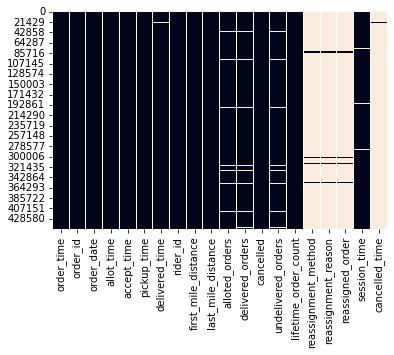

In [463]:
sns.heatmap(df.isnull(), cbar=False)

In [464]:
df = df.drop("cancelled_time", axis=1)

In [465]:
df.alloted_orders = df.alloted_orders.fillna(df.alloted_orders.mode())
df.delivered_orders = df.delivered_orders.fillna(df.delivered_orders.mode())
df.undelivered_orders = df.undelivered_orders.fillna(0)
#session times, first and last mile distances, lifetime order count

In [466]:
def encodeMethod(x):
  if(x=='auto'):
    return 1
  elif(x=='manual'):
    return 2
  else:
    return 0

In [467]:
def encodeReason(x):
  if(x=='Reassignment Request from SE portal.'):
    return 1
  elif(x=='Auto Reassignment basis Inaction. coreengine.tasks.repush_order_to_aa_bucket'):
    return 2
  elif(x=='Reassign'):
    return 3
  else:
    return 0

In [468]:
df.reassigned_order = df.reassigned_order.fillna(0)
df.reassignment_method = df.reassignment_method.apply(encodeMethod)
df.reassignment_reason = df.reassignment_reason.apply(encodeReason)

In [469]:
from datetime import datetime

def toDate(x):
    if x=="Missing_data" or len(x)!=19:
      return(datetime.strptime("2025-01-01 00:00:00", '%Y-%m-%d %H:%M:%S'))
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [470]:
from verstack import NaNImputer
imputer = NaNImputer(conservative = False, n_feats = 10,            
           fix_string_nans = True, verbose = True,                
           multiprocessing_load = 3, fill_nans_in_pure_text = True,                    
           drop_empty_cols = False, drop_nan_cols_with_constant = False)
df1 = imputer.impute(df)

NaNImputer(conservative = False, n_feats = 10,            
           fix_string_nans = True, verbose = True,                
           multiprocessing_load = 3, fill_nans_in_pure_text = True,                    
           drop_empty_cols = False, drop_nan_cols_with_constant = False                        
           feature_selection = correlation)

Dataset dimensions:
 - rows:         450000
 - columns:      19
 - mb in memory: 65.23
 - NaN cols num: 7
--------------------------

Deploy multiprocessing with 2 parallel proceses

Missing values in accept_time replaced by "Missing_data" value
--------------------------------------------------
Missing values in pickup_time replaced by "Missing_data" value
--------------------------------------------------
Missing values in delivered_time replaced by "Missing_data" value
--------------------------------------------------

NaNs imputation time: 0.18 minutes
--------------------------------------------------


In [471]:
df["order_time"] = df["order_time"].apply(toDate)
df["order_date"] = df["order_date"].apply(toDate)
df["allot_time"] = df["allot_time"].apply(toDate)
df["accept_time"] = df["accept_time"].apply(toDate) 
df["pickup_time"] = df["pickup_time"].apply(toDate)
df["delivered_time"] = df["delivered_time"].apply(toDate)

In [472]:
#Time difference between order and allot time
df["T1"] = (df["allot_time"] - df["order_time"])
df["T1"] = df["T1"].apply(lambda x: x.seconds)

In [473]:
#Time difference between order and accept time
df["T2"] = (df["accept_time"] - df["order_time"])
df["T2"] = df["T2"].apply(lambda x: x.seconds)
df['T2'] = np.where(df['accept_time']==(datetime.strptime("2025-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')), -1, 
                    df['T2'])

In [474]:
#Time difference between allot and accept time
df["T3"] = (df["accept_time"] - df["allot_time"])
df["T3"] = df["T3"].apply(lambda x: x.seconds)
df['T3'] = np.where(df['accept_time']==(datetime.strptime("2025-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')), -1, 
                    df['T3'])

In [475]:
#Time difference between pickup and delivered time
df["T4"] = (df["delivered_time"] - df["pickup_time"])
df["T4"] = df["T4"].apply(lambda x: x.seconds)
df['T4'] = np.where(df['pickup_time']==(datetime.strptime("2025-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')), -1, 
                    df['T4'])

In [476]:
df.order_time = df.order_time.apply(lambda x: x.hour)

## Removing Outliers

In [477]:
def removeOutliers(x):
  Q1 = np.percentile(df[x], 25, interpolation = 'midpoint')
  Q3 = np.percentile(df[x], 75, interpolation = 'midpoint')
  IQR = Q3 - Q1
  l = Q1-1.5*IQR
  u = Q3+1.5*IQR
  upper = np.where(df[x] >= u)
  lower = np.where(df[x] <= l)
  df.drop(upper[0], inplace = True)
  df.drop(lower[0], inplace = True)

In [478]:
col = ['alloted_orders','delivered_orders','undelivered_orders',
       'lifetime_order_count', 'first_mile_distance', 'last_mile_distance', 'session_time']
#for i in col:
  #removeOutliers(i)

## Checking Data After Cleaning

In [479]:
df.tail()

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,T1,T2,T3,T4
449995,10,130226,2021-02-06,2021-02-06 10:03:44,2021-02-06 10:04:14,2021-02-06 10:27:29,2021-02-06 10:44:08,1006,0.5789,0.19,4.0,4.0,0,0.0,127.0,0,0,0.0,369.516667,28,58,30,999
449996,10,130227,2021-02-06,2021-02-06 10:03:18,2021-02-06 10:04:34,2021-02-06 10:22:17,2021-02-06 10:31:43,279,1.9863,1.19,81.0,81.0,0,0.0,105.0,0,0,0.0,239.133333,1,77,76,566
449997,10,130228,2021-02-06,2021-02-06 10:04:06,2021-02-06 10:04:39,2021-02-06 10:19:06,2021-02-06 10:26:56,3161,1.5944,1.61,28.0,28.0,0,0.0,1488.0,0,0,0.0,204.150000,48,81,33,470
449998,10,130229,2021-02-06,2021-02-06 10:03:19,2021-02-06 10:05:41,2021-02-06 10:20:39,2021-02-06 10:30:41,9396,2.8939,4.68,72.0,72.0,0,0.0,105.0,0,0,0.0,65.583333,0,142,142,602
449999,10,130230,2021-02-06,2021-02-06 10:03:45,2021-02-06 10:05:14,2021-02-06 10:13:26,2021-02-06 10:19:41,2078,1.8925,0.09,30.0,30.0,0,0.0,108.0,0,0,0.0,212.000000,21,110,89,375


In [480]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   order_time            450000 non-null  int64         
 1   order_id              450000 non-null  int64         
 2   order_date            450000 non-null  datetime64[ns]
 3   allot_time            450000 non-null  datetime64[ns]
 4   accept_time           450000 non-null  datetime64[ns]
 5   pickup_time           450000 non-null  datetime64[ns]
 6   delivered_time        450000 non-null  datetime64[ns]
 7   rider_id              450000 non-null  int64         
 8   first_mile_distance   450000 non-null  float64       
 9   last_mile_distance    450000 non-null  float64       
 10  alloted_orders        433052 non-null  float64       
 11  delivered_orders      432659 non-null  float64       
 12  cancelled             450000 non-null  int64         
 13 

In [481]:
df.describe()

,order_time,order_id,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,T1,T2,T3,T4
count,450000.000000,450000.000000,450000.000000,450000.000000,450000.000000,433052.000000,432659.000000,450000.000000,450000.000000,449947.000000,450000.000000,450000.000000,450000.000000,446325.000000,450000.000000,450000.000000,450000.000000,450000.000000
mean,12.723800,369143.080767,7763.244016,1.229889,2.968873,104.620909,103.950448,0.011596,0.734718,853.640664,0.031344,0.052104,0.030562,220.474779,73.199969,134.017578,65.784029,1178.361920
std,3.619623,131146.906408,5592.880135,0.846183,1.884124,90.135492,89.639646,0.107057,1.056017,1502.976162,0.178792,0.313033,0.172129,176.713853,275.048691,283.917388,624.476006,3269.355818
min,0.000000,118350.000000,0.000000,0.000134,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,9.000000,257342.750000,2805.000000,0.539575,1.470000,36.000000,36.000000,0.000000,0.000000,165.000000,0.000000,0.000000,0.000000,84.100000,1.000000,33.000000,14.000000,569.000000
50%,14.000000,369842.500000,6754.000000,1.138700,2.670000,81.000000,81.000000,0.000000,0.000000,396.000000,0.000000,0.000000,0.000000,175.550000,15.000000,64.000000,37.000000,819.000000
75%,16.000000,482342.250000,11965.000000,1.853000,4.220000,147.000000,146.000000,0.000000,1.000000,948.000000,0.000000,0.000000,0.000000,316.766667,48.000000,112.000000,63.000000,1155.000000
max,21.000000,594842.000000,21566.000000,42.038100,22.410000,567.000000,562.000000,1.000000,9.000000,30469.000000,2.000000,3.000000,1.000000,1298.966667,32334.000000,15598.000000,86388.000000,86340.000000


## Train Feature Selection

In [482]:
df1 = df

In [483]:
df1 = df1.drop("order_date", axis=1)
df1 = df1.drop("accept_time", axis=1)
df1 = df1.drop("allot_time", axis=1)
df1 = df1.drop("pickup_time", axis=1)
df1 = df1.drop("delivered_time", axis=1)
df1 = df1.drop("order_time", axis=1)
df1 = df1.drop("session_time", axis=1)
#df1 = df1.drop("lifetime_order_count", axis=1)
df1 = df1.drop("reassignment_method", axis=1)
#df1 = df1.drop("reassignment_reason", axis=1)
df1 = df1.drop("reassigned_order", axis=1)
#df1 = df1.drop("first_mile_distance", axis=1)
#df1 = df1.drop("last_mile_distance", axis=1)
df1 = df1.drop("T4", axis=1) # Or use regression model to generate T4 for test data

In [484]:
dfy = df1[df1.cancelled==1]
dfy

,order_id,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_reason,T1,T2,T3
20,556773,12885,2.8438,6.81,29.0,29.0,1,0.0,449.0,1,2497,2573,76
68,556821,17557,0.8617,2.63,13.0,13.0,1,0.0,168.0,0,1,84,83
100,556853,2391,2.9217,5.20,118.0,114.0,1,4.0,860.0,1,5695,5750,55
163,556916,15229,2.1287,0.45,55.0,52.0,1,3.0,256.0,0,53,65,12
295,557048,2373,1.6053,4.84,104.0,104.0,1,0.0,3282.0,0,34,46,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
449738,129969,3027,1.7963,2.00,215.0,214.0,1,1.0,975.0,3,3114,3152,38
449922,130153,2344,2.2022,2.56,89.0,88.0,1,1.0,176.0,0,55,119,64
449928,130159,11998,1.6601,7.50,314.0,312.0,1,2.0,437.0,0,1,40,39
449932,130163,2583,0.9083,8.39,106.0,106.0,1,0.0,133.0,0,301,-1,-1


In [485]:
dfx = df1[df1.cancelled==0]
dfx = dfx.sample(frac = 0.75)
dfx

,order_id,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_reason,T1,T2,T3
78003,477853,12885,1.0043,1.01,44.0,43.0,0,1.0,449.0,0,21,65,44
22030,578783,12427,2.7241,5.30,49.0,49.0,0,0.0,385.0,0,10,87,77
430621,191567,7923,2.7627,0.54,159.0,155.0,0,4.0,2553.0,2,960,971,11
167841,406905,17988,0.5712,3.75,32.0,32.0,0,0.0,729.0,0,47,68,21
90718,490568,688,1.5970,0.98,352.0,351.0,0,1.0,1356.0,0,50,61,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202494,364713,11220,2.3196,4.03,135.0,135.0,0,0.0,1096.0,0,1,48,47
255323,340457,10014,3.3727,4.11,3.0,3.0,0,0.0,51.0,2,1180,1289,109
323590,247694,2639,1.9056,4.69,28.0,28.0,0,0.0,122.0,0,1,22,21
177677,416741,780,1.4570,5.06,146.0,146.0,0,0.0,645.0,0,31,49,18


In [486]:
df1 = pd.concat([dfx, dfy], ignore_index=True)
df1 = df1.sample(frac = 1)

In [487]:
df1

,order_id,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_reason,T1,T2,T3
169360,242556,14230,1.184200,0.19,37.0,37.0,0,0.0,172.0,0,15,128,113
125948,311482,16959,0.023313,3.00,247.0,246.0,0,1.0,1314.0,0,1,28,27
239418,381493,6473,0.134951,1.65,88.0,87.0,0,1.0,1103.0,0,3,65,62
230824,430575,4504,0.456700,1.39,26.0,26.0,0,0.0,159.0,0,1,60,59
79032,317794,10995,0.845800,2.82,108.0,107.0,0,1.0,1687.0,0,2,10,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331193,405476,484,0.762200,2.63,132.0,131.0,0,1.0,1955.0,0,25,133,108
82821,480743,15842,0.887900,13.35,113.0,112.0,0,1.0,205.0,0,1,104,103
121204,404146,11660,2.164100,0.27,48.0,48.0,0,0.0,188.0,0,12,350,338
302060,122371,10417,1.207700,5.51,2.0,2.0,0,0.0,30.0,0,57,137,80


## Model

In [488]:
!pip install XGBOOST

In [489]:
from numpy import loadtxt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [490]:
X = df1.drop("cancelled", axis=1)
Y = df1['cancelled']

In [491]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [492]:
#from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier
model = SGDClassifier(loss='modified_huber')
#model = XGBClassifier()

## Model Training and Metrics

In [493]:
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [494]:
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
y_pred_p = model.predict_proba(X_test)[::,1]
auc = metrics.roc_auc_score(y_test, y_pred_p)
print("AUC Score:",auc)
print("F1 Score:",f1_score(y_test, y_pred))


ValueError: ignored

In [ ]:
cm=confusion_matrix(y_pred, y_test)
cm

## Test Data Cleaning

In [ ]:
df_test = pd.read_csv("test.csv")

In [ ]:
df_test.shape

In [ ]:
sns.heatmap(df_test.isnull(), cbar=False)

In [ ]:
df_test.alloted_orders = df_test.alloted_orders.fillna(df.alloted_orders.mode())
df_test.delivered_orders = df_test.delivered_orders.fillna(df.delivered_orders.mode())
df_test.undelivered_orders = df_test.undelivered_orders.fillna(0)
#session times, first and last mile distances, lifetime order count

In [ ]:
df_test.reassigned_order = df_test.reassigned_order.fillna(0)
df_test.reassignment_method = df_test.reassignment_method.apply(encodeMethod)
df_test.reassignment_reason = df_test.reassignment_reason.apply(encodeReason)

In [ ]:
from verstack import NaNImputer
imputer = NaNImputer(conservative = False, n_feats = 10,            
           fix_string_nans = True, verbose = True,                
           multiprocessing_load = 3, fill_nans_in_pure_text = True,                    
           drop_empty_cols = False, drop_nan_cols_with_constant = False)
df0 = imputer.impute(df_test)

In [ ]:
df_test["order_time"] = df_test["order_time"].apply(toDate)
df_test["order_date"] = df_test["order_date"].apply(toDate)
df_test["allot_time"] = df_test["allot_time"].apply(toDate)
df_test["accept_time"] = df_test["accept_time"].apply(toDate)

In [ ]:
#Time difference between order and allot time
df_test["T1"] = (df_test["allot_time"] - df_test["order_time"])
df_test["T1"] = df_test["T1"].apply(lambda x: x.seconds)

In [ ]:
#Time difference between order and accept time
df_test["T2"] = (df_test["accept_time"] - df_test["order_time"])
df_test["T2"] = df_test["T2"].apply(lambda x: x.seconds)
df_test['T2'] = np.where(df_test['accept_time']==(datetime.strptime("2025-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')), -1, 
                    df_test['T2'])

In [ ]:
#Time difference between allot and accept time
df_test["T3"] = (df_test["accept_time"] - df_test["allot_time"])
df_test["T3"] = df_test["T3"].apply(lambda x: x.seconds)
df_test['T3'] = np.where(df_test['accept_time']==(datetime.strptime("2025-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')), -1, 
                    df_test['T3'])

In [ ]:
df_test.order_time = df_test.order_time.apply(lambda x: x.hour)

## Test Feature Selection

In [ ]:
df5 = df_test

In [ ]:
df5 = df5.drop("order_date", axis=1)
df5 = df5.drop("accept_time", axis=1)
df5 = df5.drop("allot_time", axis=1)
df5 = df5.drop("order_time", axis=1)
df5 = df5.drop("session_time", axis=1)
#df5 = df5.drop("lifetime_order_count", axis=1)
df5 = df5.drop("reassigned_order", axis=1)
df5 = df5.drop("reassignment_method", axis=1)
#df5 = df5.drop("reassignment_reason", axis=1)
#df5 = df5.drop("first_mile_distance", axis=1)
#df5 = df5.drop("last_mile_distance", axis=1)

In [ ]:
df5

## Predict

In [ ]:
Y = df5

In [ ]:
# make predictions for test data
y_pred = model.predict(Y)
predictions = [round(value) for value in y_pred]
print(y_pred)

In [ ]:
frame = { 'order_id': df5['order_id'], 'cancelled': y_pred}
result = pd.DataFrame(frame)
result.head(5)

## Result

In [ ]:
result.to_csv("submission.csv")

In [ ]:
result[result.cancelled==1].shape[0]